# Objective

We have the emotion detection dataset that we have used previously in another basic level project. Here we will try to understand the concepts of NLP in more details.

### Dataset : 

The dataset contains user messages from a social media platform. Each message has been classified into one of the 14 different emotions classes. We will assign a sentiment score between -1 and +1 to the emotions to perform sentiment score analysis.

### Scope of this project :

We have already built a basic classification model on this data. Following are the steps that we will carry out in this project.

1. Exploratory data analysis
2. Text pre-processing
3. Handling class imbalance
4. Builing Naive Bayes model
5. Model validation
6. Using Laplace smoothing (alpha hyperparameter)
7. Predicting for new datapoints
8. Sentiment score prediction using lexicons
9. Sentiment score prediction using NLTK VADER Sentiment Intensity Analyzer
10. Score prediction model accuracy comparison

# Section 1 : Exploratory Data Analysis

In [102]:
import pandas as pd
# !pip install nltk
# !pip install spacy

import nltk
import spacy
# nltk.download("all")

## Importing the data
Get the dataset information

In [103]:
# Using the file uploaded to my Github
emotion_data1 = pd.read_csv("https://raw.githubusercontent.com/A-Bhanupratap/ML_data_files/main/Emotion_Detection/Final_Emotion_Data.csv")

In [104]:
# print(emotion_data.shape)
print(emotion_data1.shape)
print(emotion_data1)

(56000, 3)
          Id    Emotion                                               Text
0          1      anger   im grabbing a minute to post i feel greedy wrong
1          1    sadness                            i didnt feel humiliated
2          2    sadness  i can go from feeling so hopeless to so damned...
3          4       love  i am ever feeling nostalgic about the fireplac...
4          5      anger                               i am feeling grouchy
...      ...        ...                                                ...
55995  55996    neutral                                   @JohnLloydTaylor
55996  55997       love                     Happy Mothers Day  All my love
55997  55998       love  Happy Mother's Day to all the mommies out ther...
55998  55999  happiness  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
55999  56000       love  @mopedronin bullet train from tokyo    the gf ...

[56000 rows x 3 columns]


In [105]:
# Since we have index we do not need the Id column
emotion_data1.drop(['Id'], axis=1, inplace=True)
emotion_data1

,Emotion,Text
0,anger,im grabbing a minute to post i feel greedy wrong
1,sadness,i didnt feel humiliated
2,sadness,i can go from feeling so hopeless to so damned...
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy
...,...,...
55995,neutral,@JohnLloydTaylor
55996,love,Happy Mothers Day All my love
55997,love,Happy Mother's Day to all the mommies out ther...
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [106]:
# Checking for null values in Text or Emotion column

print(emotion_data1['Emotion'].isnull().value_counts())
print(emotion_data1['Text'].isnull().value_counts())

False    56000
Name: Emotion, dtype: int64
False    56000
Name: Text, dtype: int64


No null values

### Frequency table of different Emotion Classes

happiness     10571
sadness        9831
neutral        8638
worry          8459
love           5146
surprise       2759
anger          2269
fear           1937
fun            1776
relief         1526
hate           1323
empty           827
enthusiasm      759
boredom         179
Name: Emotion, dtype: int64


<AxesSubplot:xlabel='count', ylabel='Emotion'>

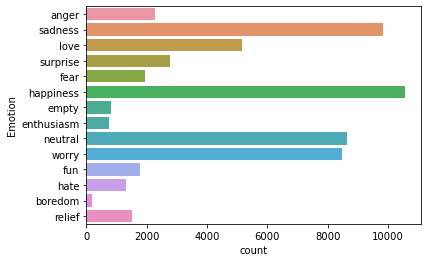

In [107]:
import seaborn as sns

print(emotion_data1['Emotion'].value_counts())
sns.countplot(y= "Emotion", data = emotion_data1)

We will be condisering four categories for classification model. Two negative and two postive categories, without considering the neutral category. These are
1. happiness
2. sadness
3. love
4. anger (combine anger and fear to one category that is anger)

We will be considering five categories for sentiment analysis
1. happiness
2. sadness
3. neutral
4. love
5. anger

So we need to keep these 5 and fear in the dataset and drop the rest of the categories. Perform EDA on these 5 categories

### EDA on selected categories

In [108]:
emotion_data = emotion_data1[emotion_data1['Emotion'].isin(['happiness','sadness','neutral','love','anger','fear'])]
emotion_data

,Emotion,Text
0,anger,im grabbing a minute to post i feel greedy wrong
1,sadness,i didnt feel humiliated
2,sadness,i can go from feeling so hopeless to so damned...
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy
...,...,...
55995,neutral,@JohnLloydTaylor
55996,love,Happy Mothers Day All my love
55997,love,Happy Mother's Day to all the mommies out ther...
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [109]:
emotion_data['Emotion'].value_counts()

happiness    10571
sadness       9831
neutral       8638
love          5146
anger         2269
fear          1937
Name: Emotion, dtype: int64

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
emotion_data['Emotion'] = emotion_data['Emotion'].replace({'fear':'anger'})
emotion_data['Emotion'].value_counts()

happiness    10571
sadness       9831
neutral       8638
love          5146
anger         4206
Name: Emotion, dtype: int64

In [112]:
# getting text length and number of words for each document in the corpus

emotion_data['text_len'] = emotion_data['Text'].apply(lambda x: len(x))
emotion_data['word_num'] = emotion_data['Text'].apply(lambda x: len(x.split()))
emotion_data

,Emotion,Text,text_len,word_num
0,anger,im grabbing a minute to post i feel greedy wrong,48,10
1,sadness,i didnt feel humiliated,23,4
2,sadness,i can go from feeling so hopeless to so damned...,108,21
3,love,i am ever feeling nostalgic about the fireplac...,92,18
4,anger,i am feeling grouchy,20,4
...,...,...,...,...
55995,neutral,@JohnLloydTaylor,16,1
55996,love,Happy Mothers Day All my love,30,6
55997,love,Happy Mother's Day to all the mommies out ther...,123,25
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,122,19


In [113]:
# Statistical parameters
emotion_data.describe()

,text_len,word_num
count,38392.000000,38392.000000
mean,81.401125,15.289513
std,47.053186,9.352588
min,1.000000,1.000000
25%,45.000000,8.000000
50%,73.000000,14.000000
75%,111.000000,21.000000
max,300.000000,66.000000


### Using histogram to visualize text length distribution for each category

In [114]:
happy_len = emotion_data['text_len'][emotion_data['Emotion']=='happiness']
sad_len = emotion_data['text_len'][emotion_data['Emotion']=='sadness']
neutral_len = emotion_data['text_len'][emotion_data['Emotion']=='neutral']
love_len = emotion_data['text_len'][emotion_data['Emotion']=='love']
anger_len = emotion_data['text_len'][emotion_data['Emotion']=='anger']

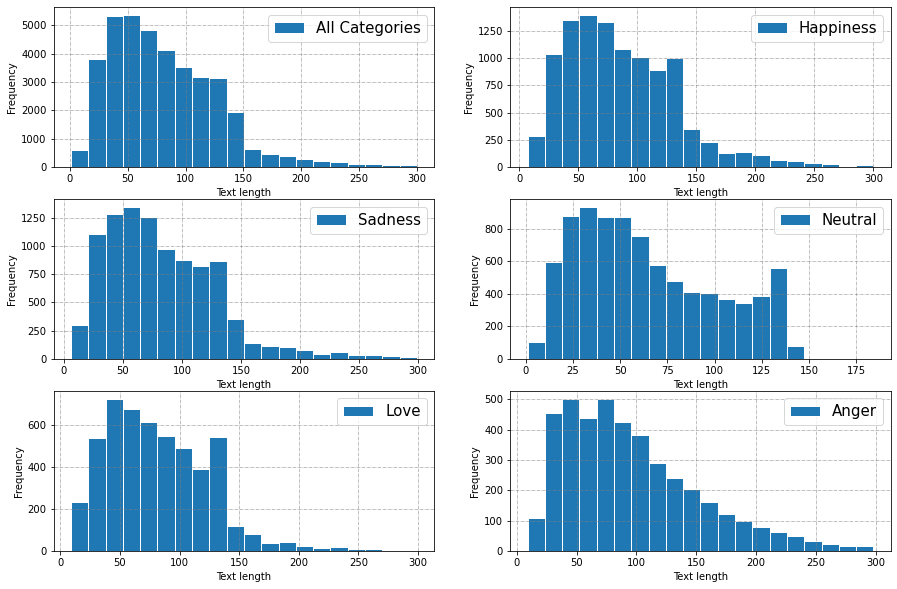

In [115]:
import matplotlib.pyplot as plt

# Creating six subplots (3 X 2)
fig, axis = plt.subplots(3, 2, figsize = (15,10))

# assigning a histogram to each subplot

axis[0, 0].hist(emotion_data['text_len'], bins=20, edgecolor='white')

axis[0, 1].hist(happy_len, bins=20, edgecolor='white')
axis[1, 0].hist(sad_len, bins=20, edgecolor='white')
axis[1, 1].hist(neutral_len, bins=20, edgecolor='white')
axis[2, 0].hist(love_len, bins=20, edgecolor='white')
axis[2, 1].hist(anger_len, bins=20, edgecolor='white')

# defining chart titles which are used as legends
cnt = 0
legends = ['All Categories', 'Happiness', 'Sadness', 'Neutral', 'Love', 'Anger']

# applying grid to each subplot
for i in [0,1,2]:
    for j in [0,1]:
        axis[i,j].grid(color ='grey', linestyle = '-.', linewidth = 0.5)
        axis[i,j].set_xlabel('Text length')
        axis[i,j].set_ylabel('Frequency')
        axis[i,j].legend([legends[cnt]], fontsize = 15)
        cnt = cnt+1

plt.show()

### Average text length

In [116]:
avg1 = emotion_data.groupby(['Emotion'], as_index=False).agg({'text_len':'mean'})
avg2 = pd.DataFrame({'Emotion':['All'], 'text_len':emotion_data['text_len'].mean()})
avg = pd.concat([avg2,avg1], ignore_index=True)
avg['text_len'] = avg['text_len'].round(decimals = 1)
avg

,Emotion,text_len
0,All,81.4
1,anger,96.0
2,happiness,87.3
3,love,82.0
4,neutral,64.5
5,sadness,83.3


In [117]:
avg1 = emotion_data.groupby(['Emotion'], as_index=False).agg({'word_num':'mean'})
avg2 = pd.DataFrame({'Emotion':['All'], 'word_num':emotion_data['word_num'].mean()})
avg_word = pd.concat([avg2,avg1], ignore_index=True)
avg_word['word_num'] = avg_word['word_num'].round(decimals = 1)
avg_word

,Emotion,word_num
0,All,15.3
1,anger,18.9
2,happiness,16.5
3,love,15.1
4,neutral,11.3
5,sadness,16.0


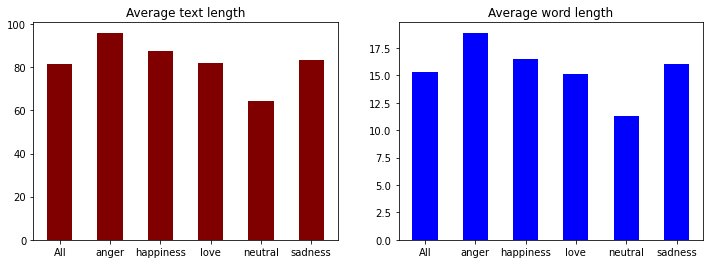

In [118]:
fig, axis = plt.subplots(1,2, figsize = (12,4))

axis[0].bar(avg['Emotion'],avg['text_len'], color = 'maroon', width = 0.5)
axis[0].set_title('Average text length')
axis[1].bar(avg_word['Emotion'],avg_word['word_num'], color='blue', width = 0.5)
axis[1].set_title('Average word length')

# plt.tight_layout()
plt.show()

### Getting relevant data for classification

In [18]:
# get the relevant dataset with four categories

emotion_data1 = emotion_data[emotion_data['Emotion'].isin(['happiness','sadness','love','anger'])].reset_index()
emotion_data1['Emotion'].value_counts()

happiness    10571
sadness       9831
love          5146
anger         4206
Name: Emotion, dtype: int64

In [19]:
# labelling the emotion classes
emotion_data1['Emotion'] = emotion_data1['Emotion'].replace({'happiness':1, 'sadness':2, 'love':3, 'anger':4})
emotion_data1['Emotion'].value_counts()

1    10571
2     9831
3     5146
4     4206
Name: Emotion, dtype: int64

# Section 2 : Text Preprocessing Function
1. Convert to lower case
2. Expand the short forms
3. Remove whitespaces, symbols, punctuations, weblinks, emails using regular expressions
4. Remove stop words
5. Spelling correction -- ignoring this
6. Lemmatization

In [20]:
# importing text blob for spelling correction
# It is recommended to use spelling correction in a formal setup only, we are applying spelling correction here
# in informal setup like social media messages

# !pip install textblob
# !python textblob.download_corpora

# from textblob import TextBlob

In [21]:
# Textblob takes a lot of time. More than 30 minutes and still it was not done. Usually it takes 2-3 minutes in this dataset
# So we are skipping spelling correction here although we intended to do it initially

In [22]:
# Dictionary for regular Expanded Forms
contra_Expan_Dict = {"ain`t": "am not","aren`t": "are not","can`t": "cannot","can`t`ve": "cannot have","`cause": "because",
"could`ve": "could have","couldn`t": "could not","couldn`t`ve": "could not have","didn`t": "did not",
"doesn`t": "does not","don`t": "do not","hadn`t": "had not","hadn`t`ve": "had not have","hasn`t": "has not",
"haven`t": "have not","he`d": "he would","he`d`ve": "he would have","he`ll": "he will","he`ll`ve": "he will have",
"he`s": "he is","how`d": "how did","how`d`y": "how do you","how`ll": "how will",
"how`s": "how does","i`d": "i would","i`d`ve": "i would have","i`ll": "i will","i`ll`ve": "i will have","i`m": "i am",
"i`ve": "i have","isn`t": "is not","it`d": "it would","it`d`ve": "it would have","it`ll": "it will","it`ll`ve": "it will have",
"it`s": "it is","let`s": "let us","ma`am": "madam","mayn`t": "may not","might`ve": "might have","mightn`t": "might not",
"mightn`t`ve": "might not have","must`ve": "must have","mustn`t": "must not","mustn`t`ve": "must not have","needn`t": "need not","needn`t`ve": "need not have",
"o`clock": "of the clock","oughtn`t": "ought not","oughtn`t`ve": "ought not have","shan`t": "shall not",
"sha`n`t": "shall not","shan`t`ve": "shall not have","she`d": "she would",
"she`d`ve": "she would have","she`ll": "she will","she`ll`ve": "she will have",
"she`s": "she is","should`ve": "should have","shouldn`t": "should not","shouldn`t`ve": "should not have","so`ve": "so have","so`s": "so is",
"that`d": "that would","that`d`ve": "that would have","that`s": "that is","there`d": "there would","there`d`ve": "there would have","there`s": "there is",
"they`d": "they would","they`d`ve": "they would have","they`ll": "they will","they`ll`ve": "they will have","they`re": "they are","they`ve": "they have",
"to`ve": "to have","wasn`t": "was not"," u ": " you "," ur ": " your "," n ": " and ","won`t": "would not",
"dis": "this","bak": "back","brng": "bring", "hrs":"hours", "ve":"have"}

# Dictionary for Expanded Forms when ' is missing
contra_Expan_Dict2 = {"aint":"am not","arent":"are not","cant":"cannot","cant`ve":"cannot have","cause":"because",
"couldnt": "could not","couldnt`ve": "could not have","didnt": "did not",
"doesnt": "does not","dont": "do not","hadnt": "had not", "hasnt": "has not",
"havent": "have not","hes": "he is","howd": "how did","howd`y": "how do you","howll": "how will",
"hows": "how is"," d ": "would","ll": "will","ll`ve": "will have","m": "am",
"isnt": "is not","it`s": "it is","lets": "let us","maam": "madam","mam":"madam","maynt": "may not","mightve": "might have","mightnt": "might not",
"mustve": "must have","mustnt": "must not","mustnt`ve": "must not have","neednt": "need not","neednt`ve": "need not have",
"oclock": "of the clock","oughtnt": "ought not","oughtnt`ve": "ought not have","shant": "shall not",
"shant`ve": "shall not have","s": "is","shouldnt": "should not","shouldnt`ve": "should not have",
"thats": "that is","theres": "there is",
"theyd": "they would","theyd`ve": "they would have",
"wasnt": "was not"," u ": " you "," ur ": " your "," n ": " and ","wont": "would not",
"dis": "this","bak": "back","brng": "bring", "hrs":"hours", "coz":"because", "+ve":"positive", "-ve":'negative',
"min":"minimum","max":"maximum", "o":"oh", "ryt":"right"}

# Function to expand the short forms
def expanded_form(x):
  if x in contra_Expan_Dict.keys():
    return(contra_Expan_Dict[x])
  elif x in contra_Expan_Dict2.keys():
    return(contra_Expan_Dict2[x])
  else:
    return(x)

# Updating stop words in spaCy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
spacy_stopwords.update({"would", "need", "do", "u", "ll", "ill", "amp", 'i', 'm', 'im', 's', 'd', 't', 've'})

# Function for Regular Expression based Cleaning
import re
def clean_with_re(x):
  x=str(x)
  x=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ", x) #Remove URLs
  x=re.sub(r'[^\w ]+', "", x) # Remove Punctuation-1
  x=re.sub(r"[,!@&\'?\.$%_]"," ", x) # Remove Punctuation-2
  x=re.sub(r"\d+"," ", x) #Remove digits
  x=re.sub(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}', "", x) #Remove email addresses
  return(x)

spacy_model = spacy.load('en_core_web_sm')

#####  Single Function for Preprocessing  ####

def pre_processing(input_data, text_col):
  # Convert all letters to lower case  
  input_data["text_col_clean"]=input_data[text_col].apply(lambda x:str(x).lower())
  # Split sentence to words. Expand abbreviated forms
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[expanded_form(t) for t in str(x).split()])
  # remove the stopwords
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[t for t in x if t not in spacy_stopwords ])
  # Regular expression cleaning
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:clean_with_re(x))
  # Lemmatization
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:" ".join([t.lemma_ for t in spacy_model(str(x))if t.lemma_ !="-PRON-" ])) 
  # Convert all letters to lower case again as lemmatization converts some letters to capital 
  input_data["text_col_clean"]=input_data['text_col_clean'].apply(lambda x: x.lower())  
  # remove stopwords created from lemmatization
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x:[t for t in str(x).split() if t not in spacy_stopwords ])
  # rejoin the remaining words to make a document
  input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x: " ".join(x) )
    
  # spelling correction using textblob
  # input_data["text_col_clean"]=input_data["text_col_clean"].apply(lambda x: "".join(TextBlob(x).correct()) )
  
  # Final Output after Pre-processing
  print(input_data[[text_col,"text_col_clean"]])

In [23]:
pre_processing(input_data=emotion_data1, text_col="Text")

                                                    Text  \
0       im grabbing a minute to post i feel greedy wrong   
1                                i didnt feel humiliated   
2      i can go from feeling so hopeless to so damned...   
3      i am ever feeling nostalgic about the fireplac...   
4                                   i am feeling grouchy   
...                                                  ...   
29749                      Succesfully following Tayla!!   
29750                     Happy Mothers Day  All my love   
29751  Happy Mother's Day to all the mommies out ther...   
29752  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...   
29753  @mopedronin bullet train from tokyo    the gf ...   

                                          text_col_clean  
0                     grab minute post feel greedy wrong  
1                                         feel humiliate  
2                  feel hopeless damn hopeful care awake  
3                 feel nostalgic fireplace 

In [24]:
emotion_data1

,index,Emotion,Text,text_len,word_num,text_col_clean
0,0,4,im grabbing a minute to post i feel greedy wrong,48,10,grab minute post feel greedy wrong
1,1,2,i didnt feel humiliated,23,4,feel humiliate
2,2,2,i can go from feeling so hopeless to so damned...,108,21,feel hopeless damn hopeful care awake
3,3,3,i am ever feeling nostalgic about the fireplac...,92,18,feel nostalgic fireplace know property
4,4,4,i am feeling grouchy,20,4,feel grouchy
...,...,...,...,...,...,...
29749,55994,1,Succesfully following Tayla!!,29,3,succesfully follow tayla
29750,55996,3,Happy Mothers Day All my love,30,6,happy mother day love
29751,55997,3,Happy Mother's Day to all the mommies out ther...,123,25,happy mother day mommy woman man long momma day
29752,55998,1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,122,19,niariley wassup beautiful follow peep new hit ...


In [25]:
# Word Cloud to identify the most frequently occuring words

# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

final_text= " ".join(emotion_data1["text_col_clean"])
print("text length = ", len(final_text))
# print(final_text)

print("word count = ", len(final_text.split()))

text length =  1370185
word count =  211796


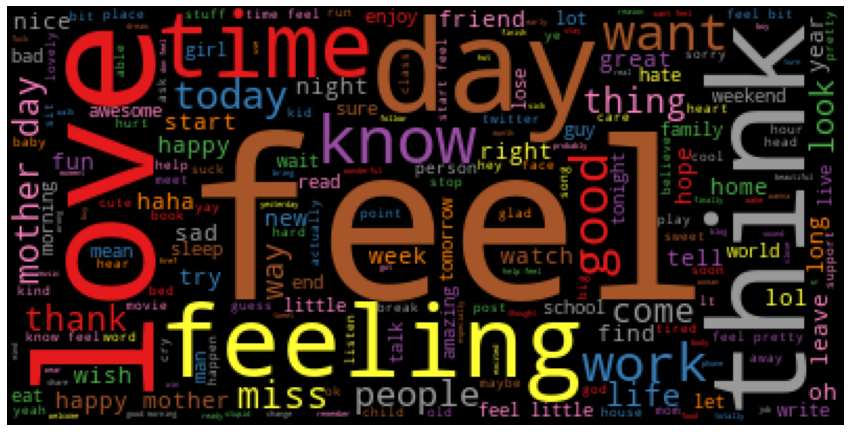

In [26]:
plt.figure(figsize = (15, 15), facecolor = None) 
wc=WordCloud(colormap='Set1').generate(final_text)
plt.imshow(wc)
plt.axis("off")
plt.show()

stopwords updated and the whole process was re-iterated till we had no random words or letters with high frequency of occurence

## Creating a Document Term Matrix (DTM)

In [27]:
# checking for null values
emotion_data1.info()
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29754 entries, 0 to 29753
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           29754 non-null  int64 
 1   Emotion         29754 non-null  int64 
 2   Text            29754 non-null  object
 3   text_len        29754 non-null  int64 
 4   word_num        29754 non-null  int64 
 5   text_col_clean  29754 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

countvec1 = CountVectorizer(min_df = 5) # freq = 5, words = 4157
dtm_v1 = pd.DataFrame(countvec1.fit_transform(emotion_data1['text_col_clean']).toarray(), columns=countvec1.get_feature_names_out(), index=None)
print(dtm_v1.shape)
dtm_v1

(29754, 4159)


,aah,aaron,abandon,abby,abc,abide,ability,abit,able,absence,...,yummy,yup,zach,zealand,zero,zombie,zone,zoo,zoom,ãââ½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# adding the target column rating to DTM
# Important to use the name which must not be a column name already. Use capitals or _
dtm_v1['Emotion'] = emotion_data1['Emotion'] # index-wise copy
dtm_v1['Emotion'].value_counts()

1    10571
2     9831
3     5146
4     4206
Name: Emotion, dtype: int64

In [30]:
# Preparing train and test data

from sklearn.model_selection import train_test_split

X = dtm_v1.drop(['Emotion'], axis = 1)
y = dtm_v1['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23803, 4159)
(23803,)
(5951, 4159)
(5951,)


# 3. Handling Class Imbalance

To handle class imbalance, we have to oversample the minority classes 3 and 4

In [31]:
# delete objects that we do not need and free up space
del emotion_data1

In [32]:
train_data = pd.concat([X_train, y_train], axis=1)
print(train_data['Emotion'].value_counts())

train_data_class_1_2 = train_data[train_data['Emotion'].isin([1,2])] # majority
train_data_class_3_4 = train_data[train_data['Emotion'].isin([3,4])] # minority

1    8486
2    7836
3    4117
4    3364
Name: Emotion, dtype: int64


In [33]:
# Oversampling of minority class : double the records

train_data_over = train_data_class_3_4.sample(len(train_data_class_3_4)*2, replace=True)

train_data_bal = pd.concat([train_data_class_1_2, train_data_over])
print(train_data_bal.shape)

(31284, 4160)


In [34]:
train_data_bal = train_data_bal.sample(frac=1).reset_index(drop=True)
print(train_data_bal.shape)
train_data_bal

(31284, 4160)


,aah,aaron,abandon,abby,abc,abide,ability,abit,able,absence,...,yup,zach,zealand,zero,zombie,zone,zoo,zoom,ãââ½,Emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
31280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
31281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
31282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
# balanced train data
train_data_bal['Emotion'].value_counts()

1    8486
3    8317
2    7836
4    6645
Name: Emotion, dtype: int64

In [36]:
del train_data, train_data_class_1_2, train_data_class_3_4, train_data_over

# 4. Building Naive Bayes Classification Model

In [37]:
# separating into x_features and target_y
X_train_bal = train_data_bal.drop(['Emotion'], axis=1)
y_train_bal = train_data_bal['Emotion']

In [38]:
del train_data_bal

In [67]:
# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
senti_model = MultinomialNB()

# Fitting model to our data
senti_model.fit(X_train_bal, y_train_bal)

MultinomialNB()

# 5. Model Validation Parameters

In [40]:
# Model Accuracy
print("Train Accuracy", senti_model.score(X_train,y_train))
print("Test Accuracy", senti_model.score(X_test,y_test))

Train Accuracy 0.7589799605091795
Test Accuracy 0.684086708116283


Accuracy on Train data = 75.9%. Accuracy on Test data = 68%. It is good. We need to check class-wise accuracy also.

In [41]:
# Prediction on train and test data
pred_train=senti_model.predict(X_train_bal)
pred_test=senti_model.predict(X_test)

In [42]:
# Train Data
print("Actual values \n", pd.Series(y_train_bal).value_counts())
print("Predicted values \n", pd.Series(pred_train).value_counts())

Actual values 
 1    8486
3    8317
2    7836
4    6645
Name: Emotion, dtype: int64
Predicted values 
 3    9167
1    7528
4    7372
2    7217
dtype: int64


In [43]:
# Test Data
print("Actual values \n", pd.Series(y_test).value_counts())
print("Predicted values \n", pd.Series(pred_test).value_counts())

Actual values 
 1    2085
2    1995
3    1029
4     842
Name: Emotion, dtype: int64
Predicted values 
 2    1757
1    1752
3    1377
4    1065
dtype: int64


## Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion Martix for Train data
cm1 = confusion_matrix(y_train_bal,pred_train)
print(cm1)
labels = np.unique(y_train_bal)
cm1_df=pd.DataFrame(cm1, index=labels, columns=labels)
print(cm1_df)

[[5862  517 1747  360]
 [ 637 6043  683  473]
 [ 939  428 6655  295]
 [  90  229   82 6244]]
      1     2     3     4
1  5862   517  1747   360
2   637  6043   683   473
3   939   428  6655   295
4    90   229    82  6244


In [46]:
# Confusion Martix for Train data in percentage
# We can get class-wise accuracy and error

percent_cm1 = (cm1_df*100)/cm1_df.sum(axis=1)[:,None] # Not using [:,None] someitmes gives weird results
round(percent_cm1, 1)

,1,2,3,4
1,69.1,6.1,20.6,4.2
2,8.1,77.1,8.7,6.0
3,11.3,5.1,80.0,3.5
4,1.4,3.4,1.2,94.0


Train data accuracy : 
Class 1 = 69.1%,  Class 2 =77.1%,  Class 3 = 80%,  Class 4 = 94%

In [312]:
# Confusion Martix for Test data
cm2 = confusion_matrix(y_test,pred_test)
labels = np.unique(y_test)
cm2_df=pd.DataFrame(cm2, index=labels, columns=labels)
print(cm2_df)

# In percentage
percent_cm2 = (cm2_df)/cm2_df.sum(axis=1)[:,None]
round(percent_cm2, 2)

      1     2    3    4
1  1303   176  489  117
2   189  1403  228  175
3   242   106  630   51
4    38    68   20  716


,1,2,3,4
1,0.62,0.08,0.23,0.06
2,0.09,0.70,0.11,0.09
3,0.24,0.10,0.61,0.05
4,0.05,0.08,0.02,0.85


### Model accuracy :

Test data accuracy : 
Class 1 = 62%,  Class 2 =70%,  Class 3 = 61%,  Class 4 = 85%

In [47]:
# 1 : happiness
# 2 : sadness
# 3 : love
# 4 : anger

# combine 1+3 = positive = 1
# combine 2+4 = negative = 2

print(y_test.value_counts())

actual = y_test.replace({3:1, 4:2})
print(actual.value_counts())

1    2085
2    1995
3    1029
4     842
Name: Emotion, dtype: int64
1    3114
2    2837
Name: Emotion, dtype: int64


In [48]:
pred_test1 = pd.Series(pred_test) # to use value_counts() we need to convert it to a pandas object. pred_test is numpy array.
print(pred_test1.value_counts())

predicted = pred_test1.replace({3:1, 4:2})
print(predicted.value_counts())

2    1757
1    1752
3    1377
4    1065
dtype: int64
1    3129
2    2822
dtype: int64


In [50]:
cm3 = confusion_matrix(actual,predicted)

labels = ['positive','negative']
cm3_df=pd.DataFrame(cm3, index=labels, columns=labels)
print("Confusion Matrix")
print(cm3_df)

accuracy = (cm3[0,0]+cm3[1,1])/cm3.sum().sum()
print("Overall accuracy = ", round(accuracy,2))

Confusion Matrix
          positive  negative
positive      2665       449
negative       464      2373
Overall accuracy =  0.85


# 6. Using Laplace smoothing

### The need for alpha hyperparameter

There can be a situation where a word is encountered in the test dataset or real world data after model deployment, which is not present in the train data. For such a word the probability will be 0. To avoid this, we add alpha to both the numerator and denominator of the Naive Bayes probability theorem equation for that document. 

In [51]:
'''
Let W* be the new word which is not present in train data
Let's assume we are dealing with two classes only - 0 and 1. We want to find whether Y (target) will be 0 or 1 for this word. 
Let's first see for Y=1

P(Y=1|W*) = P(W*|Y=1) * P(Y=1) / P(W*). Similarly for Y=0.
But P(W*|Y=1) = 0 as W* is absent from train data. (same for Y=0: P(W*|Y=0) = 0)
So, P(Y=1|W*) = 0 and P(Y=0|W*) = 0

This is not good. So we add alpha to the equation.
P(W*|Y=1) = (P(Y=1|W*)+alpha) * P(W*)/(P(Y=1)+(total classes)*alpha)

If alpha is too low or zero ==> Overfitting on train data
If alpha is too high ==> Then ignoring too much of training data - Underfitting

Optimal value of alpha has to be found out by iterating. 
Alpha=0 means no smoothing. Alpha is taken as a positive integer value.

Get maximum accuracy on train data and matching accuracy on test data.
'''

# Building NB model with alpha

senti_model_alpha = MultinomialNB(alpha=2)
senti_model_alpha.fit(X_train_bal, y_train_bal)
print("Train Accuracy", senti_model_alpha.score(X_train_bal,y_train_bal))
print("Test Accuracy", senti_model_alpha.score(X_test,y_test))

Train Accuracy 0.7853535353535354
Test Accuracy 0.6822382792807932


Here we are using four classes. If we use 2 classes we can see better lift in accuracy in test data by optimizing alpha.

In [52]:
# predicting on test data

print("Actual \n",y_test.value_counts())
pred_alpha=senti_model_alpha.predict(X_test)
pred_alpha = pd.Series(pred_alpha)
print("Predicted \n",pred_alpha.value_counts())

Actual 
 1    2085
2    1995
3    1029
4     842
Name: Emotion, dtype: int64
Predicted 
 2    1738
1    1720
3    1406
4    1087
dtype: int64


## 7. Predicting for new datapoints

In [61]:
t1 ="I hate to wake up in the morning. And worse that I have to work at a job that I dont like "
t2 ="Today is the worse day ever. I failed the exam. "
t3 = "This restaurent is super good. I am a big fan of their menu " 
t4 = "The product is fabulous! I'm using it from past 3 months and loving it" 
new_text_list=[t1,t2,t3,t4]

new_comments= pd.DataFrame({"text":new_text_list})

# Spelling Correction Sentence-wise
from textblob import TextBlob
new_comments["text_corrected"]=new_comments["text"].apply(lambda x:"".join(TextBlob(x).correct()))
new_comments

# Textblob behaves in a weird way if the first letter is capital in a word or the grammar is not correct, like missing pronouns.
# Hate = Late, Worse = Horse
# These can completely change the meaning of the sentence
# So, it is advisable to use spelling correction in formal setups like official email
# I hate = I hate, And worse = And worse
# "".join() is required as the output of TextBlob.correct is a list of letters of the sentence

,text,text_corrected
0,I hate to wake up in the morning. And worse th...,I hate to wake up in the morning. And worse th...
1,Today is the worse day ever. I failed the exam.,Today is the worse day ever. I failed the exam.
2,This restaurent is super good. I am a big fan ...,His restaurant is super good. I am a big fan o...
3,The product is fabulous! I'm using it from pas...,The product is fabulous! I'm using it from pas...


In [62]:
pre_processing(input_data=new_comments, text_col="text_corrected")

                                      text_corrected  \
0  I hate to wake up in the morning. And worse th...   
1   Today is the worse day ever. I failed the exam.    
2  His restaurant is super good. I am a big fan o...   
3  The product is fabulous! I'm using it from pas...   

                        text_col_clean  
0  hate wake morning bad work job like  
1              today bad day fail exam  
2   restaurant super good big fan menu  
3     product fabulous past month love  


### Creating DTM for the new records

In [82]:
# Create DTM for new records
countvec = CountVectorizer()
dtm_newcomment = pd.DataFrame(countvec.fit_transform(new_comments['text_col_clean']).toarray(), columns=countvec.get_feature_names(), index=None)
print(dtm_newcomment)

# copy the original DTM, words only not target variable
dtm_v1.drop(['Emotion'],axis=1,inplace=True)
dtm_v2=dtm_v1.copy()
# get column names from original DTM
dtm_new_final=pd.DataFrame(columns=dtm_v2.columns.values)
# Next step is like fitting the new DTM over the columns of old DTM. 
# The columns (words) which match with the previous DTM will get the value from new DTM. Rest columns will be null.
dtm_new_final=dtm_new_final.append(dtm_newcomment)
# replace null with 0. In this way we fit the new documents into the old DTM
dtm_new_final=dtm_new_final.fillna(0)
dtm_new_final

   bad  big  day  exam  fabulous  fail  fan  good  hate  job  ...  menu  \
0    1    0    0     0         0     0    0     0     1    1  ...     0   
1    1    0    1     1         0     1    0     0     0    0  ...     0   
2    0    1    0     0         0     0    1     1     0    0  ...     1   
3    0    0    0     0         1     0    0     0     0    0  ...     0   

   month  morning  past  product  restaurant  super  today  wake  work  
0      0        1     0        0           0      0      0     1     1  
1      0        0     0        0           0      0      1     0     0  
2      0        0     0        0           1      1      0     0     0  
3      1        0     1        1           0      0      0     0     0  

[4 rows x 22 columns]


,aah,aaron,abandon,abby,abc,abide,ability,abit,able,absence,...,yup,zach,zealand,zero,zombie,zone,zoo,zoom,ãââ½,menu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [75]:
# We have to make sure that New DTM and old DTM have same number and name of columns
print("New DTM Shape", dtm_new_final.shape)
print("Older DTM Shape",dtm_v1.shape)

New_words=[t for t in dtm_new_final.columns.values if t not in dtm_v1.columns.values]
print("Count of new words =>", len(New_words))
print("New words are => ", New_words)

New DTM Shape (4, 4160)
Older DTM Shape (29754, 4159)
Count of new words => 1
New words are =>  ['menu']


In [76]:
# remove the new word column
dtm_new_final.drop(['menu'], axis=1, inplace=True)

In [81]:
result=pd.DataFrame()
result["text"]=new_comments["text"]
result["Emotion"] = senti_model.predict(dtm_new_final)
print(result)

#1 : happiness  2: sadness  3: love  4: anger

                                                text  Emotion
0  I hate to wake up in the morning. And worse th...        2
1   Today is the worse day ever. I failed the exam.         2
2  This restaurent is super good. I am a big fan ...        3
3  The product is fabulous! I'm using it from pas...        1


# 8. Sentiment score prediction using Lexicons

In [119]:
print(emotion_data['Emotion'].value_counts())
print(emotion_data.shape)

happiness    10571
sadness       9831
neutral       8638
love          5146
anger         4206
Name: Emotion, dtype: int64
(38392, 4)


In [120]:
# Assign sentiment scores to dataset

emotion_data['senti_score'] = 0
emotion_data['senti_score'][emotion_data['Emotion']=='happiness'] = 0.75
emotion_data['senti_score'][emotion_data['Emotion']=='love'] = 1
# emotion_data['senti_score'][emotion_data['Emotion']=='neutral'] = 0
emotion_data['senti_score'][emotion_data['Emotion']=='anger'] = -1
emotion_data['senti_score'][emotion_data['Emotion']=='sadness'] = -0.75

emotion_data['senti_score'].value_counts()

 0.75    10571
-0.75     9831
 0.00     8638
 1.00     5146
-1.00     4206
Name: senti_score, dtype: int64

In [121]:
emotion_data.drop(['text_len','word_num'], axis=1, inplace=True)

In [122]:
pre_processing(input_data= emotion_data, text_col="Text")

                                                    Text  \
0       im grabbing a minute to post i feel greedy wrong   
1                                i didnt feel humiliated   
2      i can go from feeling so hopeless to so damned...   
3      i am ever feeling nostalgic about the fireplac...   
4                                   i am feeling grouchy   
...                                                  ...   
55995                                   @JohnLloydTaylor   
55996                     Happy Mothers Day  All my love   
55997  Happy Mother's Day to all the mommies out ther...   
55998  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...   
55999  @mopedronin bullet train from tokyo    the gf ...   

                                          text_col_clean  
0                     grab minute post feel greedy wrong  
1                                         feel humiliate  
2                  feel hopeless damn hopeful care awake  
3                 feel nostalgic fireplace 

In [123]:
emotion_data

,Emotion,Text,senti_score,text_col_clean
0,anger,im grabbing a minute to post i feel greedy wrong,-1.00,grab minute post feel greedy wrong
1,sadness,i didnt feel humiliated,-0.75,feel humiliate
2,sadness,i can go from feeling so hopeless to so damned...,-0.75,feel hopeless damn hopeful care awake
3,love,i am ever feeling nostalgic about the fireplac...,1.00,feel nostalgic fireplace know property
4,anger,i am feeling grouchy,-1.00,feel grouchy
...,...,...,...,...
55995,neutral,@JohnLloydTaylor,0.00,johnlloydtaylor
55996,love,Happy Mothers Day All my love,1.00,happy mother day love
55997,love,Happy Mother's Day to all the mommies out ther...,1.00,happy mother day mommy woman man long momma day
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.75,niariley wassup beautiful follow peep new hit ...


### Using Lexicons available from UIC website
http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html 

1. Use preprocessing
2. Identify words as positive and negative from the lexicon reference
3. Count of positive words = p, count of negative words = n, count of total words = t
4. sentiment score = (p-n)/t

In [124]:
# convert preprocessed sentence to list of words

emotion_data['word_list'] = emotion_data['text_col_clean'].map(lambda x : str(x).split())
emotion_data['total_len'] = emotion_data['word_list'].map(lambda x: len(x))
emotion_data

,Emotion,Text,senti_score,text_col_clean,word_list,total_len
0,anger,im grabbing a minute to post i feel greedy wrong,-1.00,grab minute post feel greedy wrong,"[grab, minute, post, feel, greedy, wrong]",6
1,sadness,i didnt feel humiliated,-0.75,feel humiliate,"[feel, humiliate]",2
2,sadness,i can go from feeling so hopeless to so damned...,-0.75,feel hopeless damn hopeful care awake,"[feel, hopeless, damn, hopeful, care, awake]",6
3,love,i am ever feeling nostalgic about the fireplac...,1.00,feel nostalgic fireplace know property,"[feel, nostalgic, fireplace, know, property]",5
4,anger,i am feeling grouchy,-1.00,feel grouchy,"[feel, grouchy]",2
...,...,...,...,...,...,...
55995,neutral,@JohnLloydTaylor,0.00,johnlloydtaylor,[johnlloydtaylor],1
55996,love,Happy Mothers Day All my love,1.00,happy mother day love,"[happy, mother, day, love]",4
55997,love,Happy Mother's Day to all the mommies out ther...,1.00,happy mother day mommy woman man long momma day,"[happy, mother, day, mommy, woman, man, long, ...",9
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.75,niariley wassup beautiful follow peep new hit ...,"[niariley, wassup, beautiful, follow, peep, ne...",12


In [125]:
emotion_data.drop(['text_col_clean'], axis=1, inplace=True)

In [126]:
# getting count of positve and negative words from stanard reference documents

file_p = pd.read_csv("https://raw.githubusercontent.com/A-Bhanupratap/ML_data_files/main/nlp_lexicon/positive-words.txt", header=None)
pos_words = list(file_p[0])

file_n = pd.read_csv("https://raw.githubusercontent.com/A-Bhanupratap/ML_data_files/main/nlp_lexicon/negative-words.txt", header=None, encoding='latin-1')
neg_words = list(file_n[0])
# there are some special characters in negative words file. 
# So we have specified the encoding as latin-1 which accomodates the special characters

In [127]:
# Get the count of positive and negative words in processed text

num_pos = emotion_data['word_list'].map(lambda x: len([i for i in x if i in pos_words]))
emotion_data['pos_cnt'] = num_pos
num_neg = emotion_data['word_list'].map(lambda x: len([i for i in x if i in neg_words]))
emotion_data['neg_cnt'] = num_neg

emotion_data

,Emotion,Text,senti_score,word_list,total_len,pos_cnt,neg_cnt
0,anger,im grabbing a minute to post i feel greedy wrong,-1.00,"[grab, minute, post, feel, greedy, wrong]",6,0,2
1,sadness,i didnt feel humiliated,-0.75,"[feel, humiliate]",2,0,1
2,sadness,i can go from feeling so hopeless to so damned...,-0.75,"[feel, hopeless, damn, hopeful, care, awake]",6,1,2
3,love,i am ever feeling nostalgic about the fireplac...,1.00,"[feel, nostalgic, fireplace, know, property]",5,0,0
4,anger,i am feeling grouchy,-1.00,"[feel, grouchy]",2,0,1
...,...,...,...,...,...,...,...
55995,neutral,@JohnLloydTaylor,0.00,[johnlloydtaylor],1,0,0
55996,love,Happy Mothers Day All my love,1.00,"[happy, mother, day, love]",4,2,0
55997,love,Happy Mother's Day to all the mommies out ther...,1.00,"[happy, mother, day, mommy, woman, man, long, ...",9,1,0
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.75,"[niariley, wassup, beautiful, follow, peep, ne...",12,1,0


In [128]:
# Should not keep denominator as 0. Change total_len=1 where total_len=0
# Check for 0

emotion_data['total_len'][emotion_data['total_len']==0].count()
# 43 records have 0 words

43

In [129]:
# Replace 0 with 1
emotion_data['total_len'] = emotion_data['total_len'].replace(0,1)

In [130]:
emotion_data['lexi_score'] = round((emotion_data['pos_cnt'] - emotion_data['neg_cnt']) / emotion_data['total_len'], 2)
emotion_data

,Emotion,Text,senti_score,word_list,total_len,pos_cnt,neg_cnt,lexi_score
0,anger,im grabbing a minute to post i feel greedy wrong,-1.00,"[grab, minute, post, feel, greedy, wrong]",6,0,2,-0.33
1,sadness,i didnt feel humiliated,-0.75,"[feel, humiliate]",2,0,1,-0.50
2,sadness,i can go from feeling so hopeless to so damned...,-0.75,"[feel, hopeless, damn, hopeful, care, awake]",6,1,2,-0.17
3,love,i am ever feeling nostalgic about the fireplac...,1.00,"[feel, nostalgic, fireplace, know, property]",5,0,0,0.00
4,anger,i am feeling grouchy,-1.00,"[feel, grouchy]",2,0,1,-0.50
...,...,...,...,...,...,...,...,...
55995,neutral,@JohnLloydTaylor,0.00,[johnlloydtaylor],1,0,0,0.00
55996,love,Happy Mothers Day All my love,1.00,"[happy, mother, day, love]",4,2,0,0.50
55997,love,Happy Mother's Day to all the mommies out ther...,1.00,"[happy, mother, day, mommy, woman, man, long, ...",9,1,0,0.11
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.75,"[niariley, wassup, beautiful, follow, peep, ne...",12,1,0,0.08


In [131]:
emotion_data.drop(['word_list','total_len','pos_cnt','neg_cnt'], axis=1, inplace=True)

In [134]:
emotion_data['lexi_score'].max() # +1.0
emotion_data['lexi_score'].min() # -1.0

-1.0

# 9. Sentiment score prediction using VADER

VADER = Valence Aware Dictionary and Sentiment Reasoner. It is tool attuned for sentiment analysis of social media data.

Compound is one of the arguments that gives a score between -1 and +1. Others are positive, negative and neutral. They give a sentence is what percent postive, what percent negative and what percent neutral. Here we are only interested in the compound score as it combines the other three parameters to give a polarity score.

In [135]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

polarity = [round(sia.polarity_scores(i)['compound'], 2) for i in emotion_data['Text']]

In [136]:
emotion_data['vader_score'] = polarity
emotion_data

,Emotion,Text,senti_score,lexi_score,vader_score
0,anger,im grabbing a minute to post i feel greedy wrong,-1.00,-0.33,-0.66
1,sadness,i didnt feel humiliated,-0.75,-0.50,0.26
2,sadness,i can go from feeling so hopeless to so damned...,-0.75,-0.17,0.08
3,love,i am ever feeling nostalgic about the fireplac...,1.00,0.00,0.13
4,anger,i am feeling grouchy,-1.00,-0.50,-0.34
...,...,...,...,...,...
55995,neutral,@JohnLloydTaylor,0.00,0.00,0.00
55996,love,Happy Mothers Day All my love,1.00,0.50,0.84
55997,love,Happy Mother's Day to all the mommies out ther...,1.00,0.11,0.61
55998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.75,0.08,0.78


In [139]:
emotion_data['vader_score'].max() # +0.98
emotion_data['vader_score'].min() # -0.98

-0.98

# 10. Finding the Best Fit Model for Score Prediction

We will find out the R-sqr value treating senti_score as actual and lexi_score, vader_score as predicted. Only finding SSE is sufficient but we will go on to find R-sqr. 

R-sqr = SSR/SST = SSR/(SSR+SSE)

In [140]:
emotion_data.reset_index(inplace=True, drop=True)

In [141]:
# function to get R-Squared value using manual OLS method

def get_rsqr(input_data, actual_score, pred_score):
    actual = input_data[actual_score]
    pred = input_data[pred_score]
    ssr = 0
    sse = 0
    
    for i in range(len(actual)):
        act_sqr = pow(actual[i],2)
        res_sqr = pow((actual[i]-pred[i]),2)
        ssr = ssr+round(act_sqr,3)
        sse = sse+round(res_sqr,3)
    
    sst = ssr+sse
    if sst==0:
        sst=1
    rsqr = round(ssr/sst, 3)
    return(rsqr)

In [142]:
rsqr_m1 = get_rsqr(input_data = emotion_data, actual_score = 'senti_score', pred_score = 'lexi_score')
print("R-squared value for lexicon score = ", rsqr_m1)

rsqr_m2 = get_rsqr(input_data = emotion_data, actual_score = 'senti_score', pred_score = 'vader_score')
print("R-squared value for Vader score = ", rsqr_m2)

R-squared value for lexicon score =  0.57
R-squared value for Vader score =  0.594


## Result

VADER Sentiment Intensity Analyzer method of finding polarity and conducting sentiment analysis is the better fit model for this data.
It slightly higher R-sqr value compared to Vader method, although the actual senti_score assigned to the emotions is subjective.
If we change the actual senti_score then the R-sqr value will change.